# Bert

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf

print("TF Version:", tf.__version__)
print("Keras Version:", tf.keras.__version__)
print(tf.config.list_physical_devices('GPU'))

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

TF Version: 2.4.1
Keras Version: 2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_csv("../data/train.csv").drop(columns=['Unnamed: 0'])[['Text', 'Outcome']]
df.shape

(1269, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1269 entries, 0 to 1268
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Text     1269 non-null   object 
 1   Outcome  1269 non-null   float64
dtypes: float64(1), object(1)
memory usage: 20.0+ KB


In [5]:
df['Outcome'].value_counts()

0.0    793
1.0    321
2.0    155
Name: Outcome, dtype: int64

## Preprocessing

In [21]:
import re
import html
from gensim.parsing.preprocessing import remove_stopwords
from functools import reduce

def composite_function(*func): 
    def compose(f, g): 
        return lambda x: f(g(x))   
    return reduce(compose, func, lambda x: x)

def convert_html(x):
    return html.unescape(x)

def remove_str_controls(x):
    patt = r"[\n\r\t]"
    return re.sub(patt, " ", x)

def remove_urls(x):
    patt1 = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    patt2 = r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    return re.sub(patt2, " ", re.sub(patt1, " ", x))

def remove_non_letters(x):
    patt = r"[^a-zA-Z',. ]"
    return re.sub(patt, "", x)

pipeline = composite_function(
    remove_non_letters,
    remove_urls,
    remove_str_controls,
    convert_html,
    str.lower
)

In [22]:
df.head()

,Text,Outcome
0,My family and friends are the only thing keepi...,1.0
1,I’m the guy who puts food in random places in ...,0.0
2,Has anyone here had their life completely turn...,0.0
3,i'm so tired and cold i'm tired\n\nand i just ...,1.0
4,"They said ma days are numbered, but I keep wak...",0.0


## Augmentations

In [23]:
import nlpaug.augmenter.word as naw
from textaugment import Translate, Word2vec, Wordnet

def back_translation_fr(x, src='en', to='fr'):
    t = Translate(src=src, to=to, p=0.5)
    try:
        return t.augment(x)
    except:
        return x

def back_translation_nl(x, src='en', to='nl'):
    t = Translate(src=src, to=to, p=0.5)
    try:
        return t.augment(x)
    except:
        return x

def word2vec(x):
    return naw.SynonymAug().augment(x)

def contextual_embedding(x):    
    return naw.ContextualWordEmbsAug(top_k=20, optimize=True).augment(x, num_thread=16)

contextual_pipeline = composite_function(
    remove_non_letters,
    contextual_embedding,
    remove_urls,
    remove_str_controls,
    convert_html,
    str.lower
)

word2vec_pipeline = composite_function(
    remove_non_letters,
    word2vec,
    remove_urls,
    remove_str_controls,
    convert_html,
    str.lower
)

rtt_fr_pipeline = composite_function(
    remove_non_letters,
    back_translation_fr,
    remove_urls,
    remove_str_controls,
    convert_html,
    str.lower
)

rtt_nl_pipeline = composite_function(
    remove_non_letters,
    back_translation_nl,
    remove_urls,
    remove_str_controls,
    convert_html,
    str.lower
)

def get_augmented_df(data, pipeline):
    df = pd.DataFrame()
    data = data[['Outcome', 'cleaned']].reset_index()
    df['Outcome'] = data['Outcome'].copy()
    df['original'] = data['cleaned'].copy()
    df['augmented'] = [pipeline(x) for x in tqdm(data['cleaned'])]
    return df

In [24]:
from sklearn.model_selection import train_test_split

seed = 42

X = df['Text']
y = df['Outcome'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
X_train_data = pd.DataFrame(X_train.copy())
X_train_data['Outcome'] = y_train
X_train_data['cleaned'] = [pipeline(x) for x in tqdm(X_train)]

X_val_data = pd.DataFrame(X_val.copy())
X_val_data['Outcome'] = y_val
X_val_data['cleaned'] = [pipeline(x) for x in tqdm(X_val)]

X_train_data.head()

  0%|          | 0/1015 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

,Text,Outcome,cleaned
1251,"Don’t know what to do So, I’m new to this. Fir...",1,"dont know what to do so, im new to this. first..."
1108,I took the time to clean off my desk that’s be...,0,i took the time to clean off my desk thats bee...
368,Do people make you think that everything you d...,0,do people make you think that everything you d...
506,I am worried that I may be an Incel. Whenever ...,0,i am worried that i may be an incel. whenever ...
831,"I need help but i dont want it. Im shaking, my...",0,"i need help but i dont want it. im shaking, my..."


In [31]:
word2vec_df = get_augmented_df(X_train_data, word2vec_pipeline)
word2vec_df.to_csv("../data/export/word2vec_df.csv", index=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

In [32]:
rtt_fr_df = get_augmented_df(X_train_data, rtt_fr_pipeline)
rtt_fr_df.to_csv("../data/export/rtt_fr_df.csv", index=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

In [33]:
rtt_nl_df = get_augmented_df(X_train_data, rtt_nl_pipeline)
rtt_nl_df.to_csv("../data/export/rtt_nl_df.csv", index=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

In [34]:
contextual_df = get_augmented_df(X_train_data, contextual_pipeline)
contextual_df.to_csv("../data/export/contextual_df.csv", index=False)

  0%|          | 0/1015 [00:00<?, ?it/s]

## Oversampling / Undersampling

In [37]:
import glob

aug_df = pd.DataFrame()

for filepath in glob.glob("../data/export/*.csv"):
    input_df = pd.read_csv(filepath)
    aug_df = pd.concat([aug_df, input_df], ignore_index=True)

aug_df = aug_df[['Outcome', 'augmented']].rename(columns={'augmented': 'Text'}) 
ori_df = df

training_data = pd.concat([aug_df, ori_df], ignore_index=True)
training_data.dropna(inplace=True)
training_data.drop_duplicates(inplace=True)
training_data.reset_index(drop=True, inplace=True)

training_data.to_csv("../data/export/augmented_train_data.csv", index=False)

print(len(training_data))
training_data.head()

4299


,Outcome,Text
0,1.0,"i know what to do so, im new to this. first ti..."
1,0.0,i have the lead to clean off our desk who been...
2,0.0,do people make you think that everything you b...
3,0.0,i always worried that i must be your ex. whene...
4,0.0,"i need you but i dont want it. im shaking, bec..."


In [38]:
training_data['Outcome'].value_counts()

0.0    2683
1.0    1089
2.0     527
Name: Outcome, dtype: int64

In [39]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

X, y = pd.DataFrame(training_data['Text']), training_data['Outcome'].values

# # define oversampling strategy
# over = RandomOverSampler(sampling_strategy='auto')
# # fit and apply the transform
# X, y = over.fit_resample(X, y)

y = np.array(y, dtype=np.int32)

pd.Series(y).value_counts()

0    2683
1    1089
2     527
dtype: int64

In [41]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {x:y for x, y in zip(np.unique(y), weights)}
class_weights

{0: 0.5341036153559449, 1: 1.3158861340679522, 2: 2.7191650853889944}

## Preparing Bert Inputs

In [45]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42
num_classes = len(np.unique(y_train))

train_ds = tf.data.Dataset.from_tensor_slices(
    (training_data['Text'].values, training_data['Outcome'])
).batch(batch_size, drop_remainder=False).cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val_data['cleaned'].values, X_val_data['Outcome'])
).batch(batch_size, drop_remainder=False).cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Title: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

Title: b'i know what to do so, im new to this. first time posting on reddit or anywhere. ive talked with people in the past, no real contact. from anyones perspective, i have a good life. wife, kids, good career, healthy family. literally nothing to complain about. most anyone would say im lucky, and i am for the most part. im an ass for complaining. despite all that, i wish i was dead. every morning. all the time. i dont have the courage to kill myself. death would be so many people around me. the logical part of me knows it isnt true, but my gut tells me theyd all be better off without me here, even if they dont know him. i give no value to anything. theres nothing i really can contribute. im, and ive felt this way for as long if i can remember. i cant connect with people. not really. im dont have no legit friends, just people who kinda know me. im incapable of making emotional connections. i have nobody to talk with about this. i dont know what im trying to accomplish by posting thi

In [47]:
#@title Choose a BERT model to fine-tune

# bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
# bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'
bert_model_name = 'electra_small'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [48]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [49]:
text_test = ['How to calculate $ \\mathbb{Z}[x] /\\langle2x-1\\rangle $?']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2129  2000 18422  1002  1032  8785 10322  1063  1062  1065  1031]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [50]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [51]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/electra_small/2
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[-0.72477484  0.6809698  -0.39734    -0.3955259   0.62060785  0.67219
  0.9177327   0.956274    0.25563103  0.62697214 -0.46784523 -0.59668225]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.91763103  0.83092016 -0.4204863  ...  1.4840637  -0.953829
   0.4283726 ]
 [ 0.11150239 -0.7992214  -0.7701465  ...  0.17320415  0.7740885
   0.604264  ]
 [ 0.20649894 -0.13375399 -0.6381452  ... -0.31388146  0.06313606
   0.7871695 ]
 ...
 [ 0.37578183 -0.7784546  -0.32506758 ...  0.5195869  -0.23459892
   0.13379887]
 [-0.03044392 -0.5364127  -0.18415692 ... -0.14017026 -1.0072703
   0.25326577]
 [-0.05187959 -0.9360568   0.5809163  ...  0.49485448 -1.3509554
   0.6204972 ]]


In [97]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
#     net = tf.keras.layers.Dense(256, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [98]:
# classifier_model = tf.keras.models.load_model("../models/30ksampling_weighted_42k_electra_base_epoch_1", compile=False)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.18194102 0.0400969  0.7779621 ]], shape=(1, 3), dtype=float32)


In [99]:
epochs = 8
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


In [104]:
from focal_loss import SparseCategoricalFocalLoss
loss = SparseCategoricalFocalLoss(gamma=3)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
]

In [105]:
classifier_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [106]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='auto', restore_best_weights=True)

In [107]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 13548801    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
____________________________________________________________________________________________

## Training

In [108]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(
    x=train_ds,
    epochs=epochs,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[callbacks]
)

# classifier_model.save("../models/electra_small", include_optimizer=False)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/8
269/269 [==============================] - 49s 114ms/step - loss: 0.7262 - accuracy: 0.3368 - val_loss: 0.2776 - val_accuracy: 0.5512
Epoch 2/8
269/269 [==============================] - 30s 110ms/step - loss: 0.3506 - accuracy: 0.5468 - val_loss: 0.2419 - val_accuracy: 0.6378
Epoch 3/8
269/269 [==============================] - 30s 110ms/step - loss: 0.2135 - accuracy: 0.7150 - val_loss: 0.1895 - val_accuracy: 0.7087
Epoch 4/8
269/269 [==============================] - 30s 111ms/step - loss: 0.1027 - accuracy: 0.8331 - val_loss: 0.2081 - val_accuracy: 0.7205
Epoch 5/8
269/269 [==============================] - 30s 112ms/step - loss: 0.0653 - accuracy: 0.8859 - val_loss: 0.1490 - val_accuracy: 0.7795
Epoch 6/8
269/269 [==============================] - 30s 110ms/step - loss: 0.0343 - accuracy: 0.9344 - val_loss: 0.1165 - val_accuracy: 0.8465
Epoch 7/8
269/269 [==============================] - 30s 112ms/step - loss:

## Evaluation

In [109]:
loss, accuracy = classifier_model.evaluate(val_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

16/16 [==============================] - 1s 36ms/step - loss: 0.0688 - accuracy: 0.8780
Loss: 0.06876272708177567
Accuracy: 0.8779527544975281


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


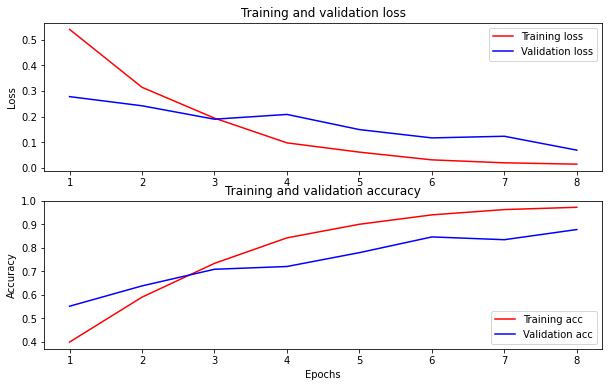

In [110]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [111]:
%%time
results = classifier_model.predict(val_ds)

CPU times: user 1.78 s, sys: 130 ms, total: 1.91 s
Wall time: 1.36 s


In [112]:
y_pred = np.array(tf.argmax(results, axis=1))
y_true = np.concatenate([np.array(x[1]) for x in val_ds])

In [113]:
from sklearn.metrics import f1_score

f1_score(y_true, y_pred, average='macro')

0.8623285795634873

In [114]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       159
           1       0.76      0.89      0.82        64
           2       0.77      0.97      0.86        31

    accuracy                           0.88       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.89      0.88      0.88       254



In [115]:
confusion_matrix(y_true, y_pred)

array([[136,  17,   6],
       [  4,  57,   3],
       [  0,   1,  30]])

## Testing

In [116]:
def get_classification(logits):
    return np.array(tf.argmax(logits, axis=1))

In [117]:
test_df = pd.read_csv("../data/test.csv")
test_df['Outcome'] = test_df['Outcome'].astype(int)

In [118]:
test_df['cleaned'] = [pipeline(x) for x in tqdm(test_df['Text'])]

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['cleaned'].values, test_df['Outcome'].values)
).batch(batch_size, drop_remainder=False)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

  0%|          | 0/318 [00:00<?, ?it/s]

In [119]:
%%time
test_pred = classifier_model.predict(test_ds)
y_pred = get_classification(test_pred)
y_true = np.concatenate([np.array(x[1]) for x in test_ds])

CPU times: user 1.14 s, sys: 123 ms, total: 1.26 s
Wall time: 599 ms


In [120]:
f1_score(y_true, y_pred, average='macro')

0.5933006535947712

In [121]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       199
           1       0.51      0.69      0.59        80
           2       0.50      0.33      0.40        39

    accuracy                           0.69       318
   macro avg       0.61      0.59      0.59       318
weighted avg       0.70      0.69      0.69       318



In [122]:
confusion_matrix(y_true, y_pred)

array([[152,  38,   9],
       [ 21,  55,   4],
       [ 12,  14,  13]])